# Difference in significance between cash and wstat analysis

We have two types of Poisson likelihoods defined within `gammapy`, the two most commonly used ones in gamma ray astronomy:

- `Cash`: Cash statitics is used when the expected number of background events is known, ie, obtained from the background IRF or a background model. Within gammapy, this is used by the `MapDataset` and `SpectrumDataset` for 3D and 1D analysis resepctively.
- `WStat`: When the background is measured directly from sources free regions (eg: pointing at a source free region, or reflected regions or a ring around the region of interest, we use WStat. Here, the number of measured off counts is a Poission random variable, and thus, the likelihood has to account for the background estimation unceratinties. Within gammapy, this is used by `MapDatasetOnOff` and `SpectrumDatasetOnOff`

For an introduction to the differences betwene the two, see https://docs.gammapy.org/dev/stats/index.html. This notebook further explores how these differences show up during modelling and fitting - in the detection significance and the error bars on the parameters.

To do so, we 

- simulate a spectrum using the CTA IRFs and background as estimated from the IRF, and fit it. `Cash` statistics is used in this case.
- Create a `SpectrumDatasetOnOff` from the above; fit using `wstat`
 

## Standard imports...


In [1]:
import gammapy
gammapy.__version__
# ps: This notebook works on the latest dev version of gammapy

'0.17.dev1223+g2749f0ebc.d20200820'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    BackgroundModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis, WcsGeom
from gammapy.stats import CashCountsStatistic, WStatCountsStatistic

## Simple count statistics

As shown in https://docs.gammapy.org/dev/stats/index.html, `WStat` yields lower significance values than `Cash`. This difference depends upon the value of `alpha(=acceptance_on/acceptance_off`), and the `wstat` significances tend towards `cash` with decreasing `alpha`.

Let us assume that we have measured `n_on = 20` from a source region. With the expected number of background events, `$\mu_{bkg}$ = 5`, the `cash` significance is obtained by:

In [3]:
n_on = 20
mu_bkg = 5
cash_stat = CashCountsStatistic(n_on=n_on, mu_bkg=mu_bkg)
cash_stat.significance

5.044975167906737

Now, we compute `wstat` significance when we have `n_off` measured off counts from background regions for increasing `acceptance_off` (for the same `n_off/acceptane_off`), and see how it varies with `alpha`

In [4]:
wstat_sig = []
acceptance_off = np.linspace(1,100,50)
n_off = mu_bkg*acceptance_off
for off, al in zip(n_off, acceptance_off):
    stat = WStatCountsStatistic(n_on=n_on, n_off=off, alpha=1.0/al)
    wstat_sig.append(stat.significance)

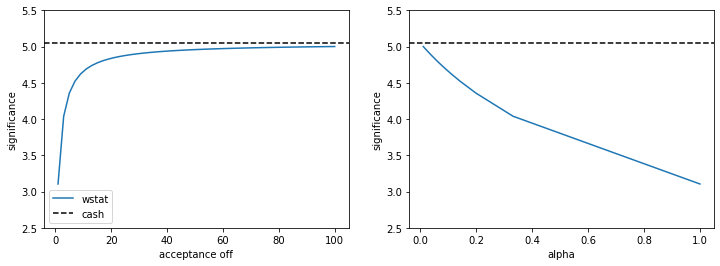

In [5]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
ax1.plot(acceptance_off, wstat_sig, label="wstat")
ax1.axhline(cash_stat.significance, color='black', ls="dashed", label="cash")
ax1.set_ylim(2.5,5.5)
ax1.set_xlabel("acceptance off")
ax1.set_ylabel("significance")

ax2 = plt.subplot(122)
ax2.plot(1.0/acceptance_off, wstat_sig)
ax2.axhline(cash_stat.significance, color='black', ls="dashed")
ax2.set_ylim(2.5,5.5)
ax2.set_xlabel("alpha")
ax2.set_ylabel("significance")

ax1.legend();

## Spectral analysis

We now illustrate this concept in spectral fitting. We use a simple powerlaw as the spectral shape, and take the backround from the IRFs. The simulated source spectrum remains the same in the 2 cases.

In [6]:
# Define simulation parameters parameters
livetime = 1 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)


In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.8,
    amplitude=4e-13 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=model_simu, name="source")

In [8]:
# Load the IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [9]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



## Simulate and fit a `SpectrumDataset`

### Simulate

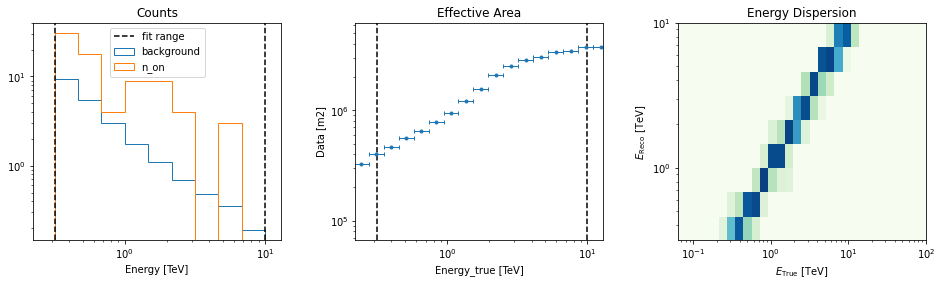

In [10]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)
# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=200)
dataset.peek()

### Fit

Now fit the simualted spectrum using a power law.

In [11]:
model_fit = PowerLawSpectralModel(
    index=3.0,
    amplitude=1e-13 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
model_fit = SkyModel(spectral_model=model_fit, name="fit")
dataset.models = None
L0 = dataset.stat_sum()
dataset.models.append(model_fit)
fit_cash = Fit([dataset])
result_cash = fit_cash.run()
L1 = dataset.stat_sum()
sig_cash = L0 - L1
print("Cash del(TS) = ", sig_cash)

Cash del(TS) =  89.56912547902652


In [12]:
print(result_cash.parameters.to_table())

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
    index 2.855e+00                nan nan  False 2.096e-01
amplitude 5.394e-13 cm-2 s-1 TeV-1 nan nan  False 8.841e-14
reference 1.000e+00            TeV nan nan   True 0.000e+00


## Repeat the same using Wstat
We convert the above dataset into an `onoff` dataset, assuming `alpha=0.2`. Note the absence of the background model in this case, but rather, the usage of off counts.

In [13]:
dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)
dataset_onoff.fake(background_model=dataset.background, random_state=1)


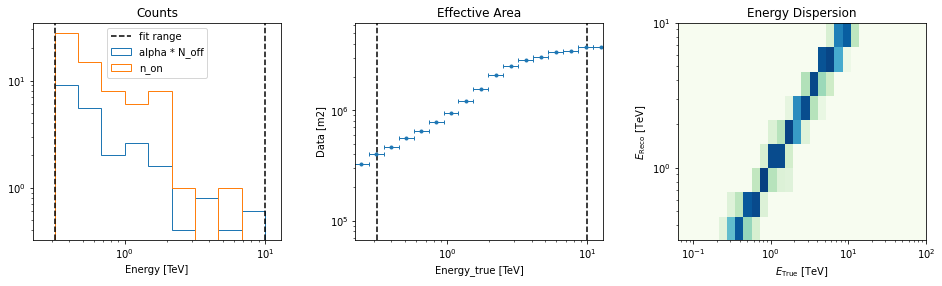

In [14]:
dataset_onoff.peek()

## Now fit

In [15]:
model_fit2 = PowerLawSpectralModel(
    index=3.0,
    amplitude=1e-13 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
model_fit2 = SkyModel(spectral_model=model_fit2, name="fit")

In [16]:
dataset_onoff.models = None
L2 = dataset_onoff.stat_sum()
dataset_onoff.models = model_fit2
fit_wstat = Fit([dataset_onoff])
result_wstat = fit_wstat.run()
L3 = dataset_onoff.stat_sum()
sig_wstat = (L2-L3)
print("WStat del(TS) = ", sig_wstat)

WStat del(TS) =  42.01550432649342


In [17]:
print(result_wstat.parameters.to_table())

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
    index 3.274e+00                nan nan  False 2.783e-01
amplitude 3.546e-13 cm-2 s-1 TeV-1 nan nan  False 7.685e-14
reference 1.000e+00            TeV nan nan   True 0.000e+00


As expected, `sig_wstat = 89` is much less than `sig_cash = 42`.
The symmetric errors from the covariance matrix are also slightly larger for `wstat` as compared to `cash` for the index (`0.28` vs `0.21`, respectively, and comparable for the amplitude. 
For clarity, let's look at the likelihood profiles of the fitted parameters in the 2 cases.
(The dotted black line corresponds to the injected parameters.)

In [18]:
profile_cash_amp = fit_cash.stat_profile(parameter='amplitude', 
                                         nvalues=21, 
                                         bounds=3,
                                         reoptimize=True)
profile_cash_ind = fit_cash.stat_profile(parameter='index', 
                                         nvalues=21,
                                         bounds=3,
                                         reoptimize=True)

profile_wstat_amp = fit_wstat.stat_profile(parameter='amplitude', 
                                           nvalues=21,
                                           bounds=3,
                                           reoptimize=True)
profile_wstat_ind = fit_wstat.stat_profile(parameter='index', 
                                           nvalues=21,
                                           bounds=3,
                                           reoptimize=True)

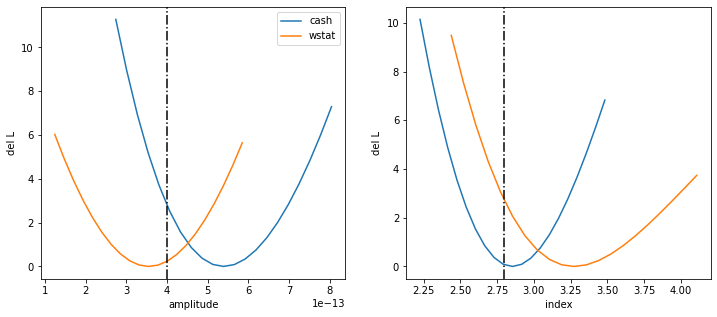

In [19]:
plt.figure(figsize=(12,5))

ax1 = plt.subplot(121)
ax1.plot(profile_cash_amp["values"], profile_cash_amp["stat"] - L1, label="cash")
ax1.plot(profile_wstat_amp["values"], profile_wstat_amp["stat"] - L3, label="wstat")
ax1.axvline(model_simu.parameters['amplitude'].value, color='black', ls='-.')
ax1.set_xlabel("amplitude")
ax1.set_ylabel("del L")

ax2 = plt.subplot(122)
ax2.plot(profile_cash_ind["values"], profile_cash_ind["stat"] - L1, label="cash")
ax2.plot(profile_wstat_ind["values"], profile_wstat_ind["stat"] - L3, label="wstat")
ax2.set_xlabel("index")
ax2.set_ylabel("del L")
ax2.axvline(model_simu.spectral_index(1.0*u.TeV), color='black', ls='-.')

ax1.legend()

### Dependance on `alpha`

Similar to the Fig 1 (for the case of counts statistics), we explore how the difference in significance changes with increasing `acceptance_off`, ie, decreasing `alpha`. 

In [20]:
def fit_wstat(a_off):
    model_fit3 = PowerLawSpectralModel(
        index=3.0,
        amplitude=1e-13 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        )
    model_fit3 = SkyModel(spectral_model=model_fit3, name="fit")
    dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=a_off
    )
    dataset_onoff.models = None
    L0 = dataset_onoff.stat_sum()
    dataset_onoff.models = model_fit3
    fit = Fit([dataset_onoff])
    result = fit.run()
    if result.success is False:
        print("Not converged for ", a_off)
        return
    L1 = dataset_onoff.stat_sum()
    return {'significance': (L0-L1), 
            'amplitude': model_fit3.parameters['amplitude'].value, 
            'amplitude_error' :model_fit3.parameters['amplitude'].error,
            'index' :model_fit3.parameters['index'].value,
            'index_error':model_fit3.parameters['index'].error,
           }

In [21]:
alpha_ = np.linspace(1,100,25)
sig = []
amp = []
index = []
amp_e = []
ind_e =[]
for al in alpha_:
    ws = fit_wstat(al)
    sig.append(ws['significance'])
    amp.append(ws['amplitude'])
    index.append(ws['index'])
    amp_e.append(ws['amplitude_error'])
    ind_e.append(ws['index_error'])
    

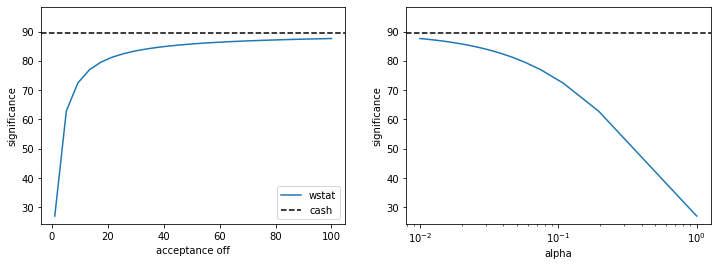

In [22]:
plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
ax1.plot(alpha_, sig, label="wstat")
ax1.axhline(sig_cash, color='black', ls="dashed", label="cash")
ax1.set_ylim(sig[0]*0.9,sig_cash*1.1)
ax1.set_xlabel("acceptance off")
ax1.set_ylabel("significance")

ax2 = plt.subplot(122)
ax2.plot(1/alpha_, sig)
ax2.axhline(sig_cash, color='black', ls="dashed")
ax2.set_ylim(sig[0]*0.9,sig_cash*1.1)
ax2.set_xlabel("alpha")
ax2.semilogx()
ax2.set_ylabel("significance")

ax1.legend();

As we see, slight difference exists even for `alpha = 0.01`. 
For spectral analysis with reflected regions, standard values of alpha is off the order of `0.1`, where the difference maybe significant.
For the case of morphological analysis with ring background, typical alpha values are very small (`<1e-4`), and hence the differences might not be very pronounced. However, it is important to keep this issue in mind, specially while dealing with large exclusion regions.
It might often be useful to do similar simulations before drawing conclusions on the real data.

While comparing results between different analysis tools, eg `HAP`, `gammapy` or `ctools`, it is important to verify the statistics used before attributing some observed differences to the analysis tools.